In [88]:
import math
import os.path
import csv
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [89]:
folder = os.path.join("data_score", "gme")
price_file = os.path.join(folder, "price.csv")
sentiment_file = os.path.join(folder, "sentiment_all.csv")

In [90]:
price = []
price_time = []
with open(price_file, 'r') as csv_file:
    reader = csv.DictReader(csv_file)
    for row in reader:
        price.append(float(row["close-price"]))
        price_time.append(row["datetime"])

In [91]:
sentiment = []
sentiment_time = []
with open(sentiment_file, 'r') as csv_file:
    reader = csv.DictReader(csv_file)
    for row in reader:
        sentiment.append([float(row["updated_positive"]), float(row["updated_negative"])])
        sentiment_time.append(row["datetime"])

In [92]:
price_to_sentiment = []
for time in price_time:
    time_pre_hour = (datetime.strptime(time, "%Y-%m-%d %H:%M") - timedelta(hours=1)).strftime("%Y-%m-%d %H")
    if time_pre_hour in sentiment_time:
        price_to_sentiment.append(sentiment_time.index(time_pre_hour))
    else:
        price_to_sentiment.append(-1)

In [93]:
def prepare_input_data(X, Z, price_to_sentiment, window_size):
    X_train, y_train = [], []
    for i in range(window_size, len(X)):
        x_slice = np.array(X[i-window_size:i])
        # x_slice = np.zeros(window_size)
        index = price_to_sentiment[i]
        Z=np.array(Z)
        z_slice = Z[max(0, index-(window_size-1)):index+1, :]
        if z_slice.shape[0] < window_size:
            num_rows_to_pad = window_size - z_slice.shape[0]
            pad_width = ((num_rows_to_pad, 0), (0, 0))
            z_slice = np.pad(z_slice, pad_width, mode='constant', constant_values=0)
        X_train.append(np.hstack((x_slice.reshape(-1, 1), z_slice)))
        y_train.append(X[i])
    return np.array(X_train), np.array(y_train)

In [94]:
scaler = MinMaxScaler()

price = scaler.fit_transform(np.array(price).reshape(-1, 1))
sentiment = scaler.fit_transform(sentiment)

In [95]:
window_size = 48
X_train, y_train = prepare_input_data(price, sentiment, price_to_sentiment, window_size)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

In [96]:
model = Sequential()
model.add(LSTM(units=256, return_sequences = True, input_shape=(window_size, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units = 128, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 96, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 48))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [97]:
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/30
12/12 [==============================] - 26s 661ms/step - loss: 0.0536 - val_loss: 0.0703
Epoch 2/30
12/12 [==============================] - 3s 237ms/step - loss: 0.0194 - val_loss: 0.0049
Epoch 3/30
12/12 [==============================] - 3s 226ms/step - loss: 0.0141 - val_loss: 0.0063
Epoch 4/30
12/12 [==============================] - 3s 229ms/step - loss: 0.0153 - val_loss: 0.0019
Epoch 5/30
12/12 [==============================] - 3s 236ms/step - loss: 0.0123 - val_loss: 0.0027
Epoch 6/30
12/12 [==============================] - 3s 250ms/step - loss: 0.0135 - val_loss: 7.4138e-04
Epoch 7/30
12/12 [==============================] - 3s 253ms/step - loss: 0.0136 - val_loss: 8.0153e-04
Epoch 8/30
12/12 [==============================] - 3s 237ms/step - loss: 0.0103 - val_loss: 0.0025
Epoch 9/30
12/12 [==============================] - 3s 272ms/step - loss: 0.0090 - val_loss: 0.0039
Epoch 10/30
12/12 [==============================] - 3s 257ms/step - loss: 0.0095 - val_los

12/12 [==============================] - 7s 104ms/step


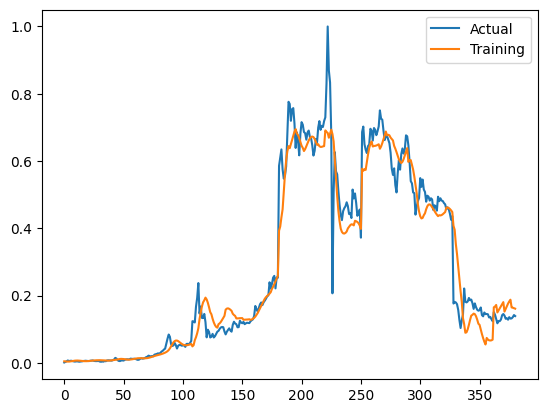

In [98]:
y_pred = model.predict(X_train)

# Plot the actual y_test values against the predicted values
plt.plot(y_train, label='Actual')
plt.plot(y_pred, label='Training')
plt.legend()
plt.show()

3/3 [==============================] - 0s 98ms/step


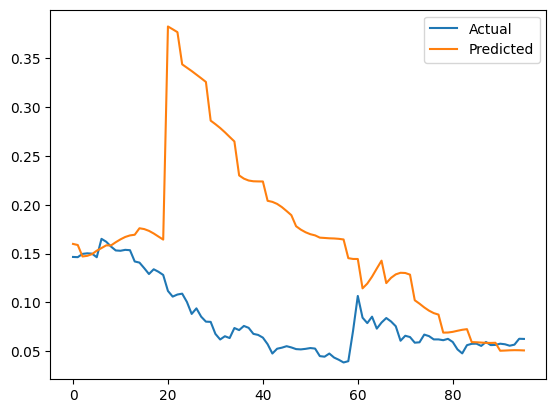

In [99]:
# y_pred = []
# y_pre = model.predict(X_test[0, :, :].reshape(1, 100, 3))
# y_pred.append(y_pre[0][0])
# for i in range(1, len(X_test)):
#     X_test[i, -1, 0] = y_pre
#     y_pre = model.predict(X_test[i, :, :].reshape(1, 100, 3))
#     y_pred.append(y_pre[0][0])

y_pred = model.predict(X_test)
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()